In [1]:
#useful: https://www.kdnuggets.com/2018/04/robust-word2vec-models-gensim.html

import csv
import nltk
import re
import numpy as np
import time
import gensim, logging
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial import cKDTree
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer



C:\Users\samir\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Load data

In [2]:

with open('./ios/youtube/total_info.txt') as f:
    reader = csv.reader(f, delimiter="\t")
    d = list(reader)

ratings = []
reviews = []
titles = []
dates = []
versions = []

for line in d:
    vals = line[0].split("******")
    ratings.append(float(vals[0]))
    reviews.append(vals[1])
    titles.append(vals[2])
    dates.append(vals[3])
    versions.append(vals[4])
    


In [3]:
len(reviews)

37718

In [4]:
reviews[0:3]

["video still open in browser den can tap to open in app . it's not as describe .",
 "i can't load any of the video on my youtube ever since i update the app . please fix this problem as soon as possible .",
 'after the update it get more worse come on youtube step up .']

# Preprocess all review text

In [6]:
stop_words = stopwords.words('english')
def custom_preprocessor(text):
    porter = PorterStemmer()

    #split into sentences
    sentences = sent_tokenize(text)
    
    final_sentences = []
    
    for sentence in sentences:
        sentence_split = sentence.split(" ")
        
        #remove words in not in stop words, and make lowercase
        words = [word.lower() for word in sentence_split if word.lower() not in stop_words]
        #get rid of words with non alphanumeric characters in it
        #(should we replace these with a token?)
        words = [word for word in words if word.isalpha()]
        #stem words
        words = [porter.stem(word) for word in words]

        final_sentences.append(" ".join(words))
        
        #consider joining sentences with a stop token
    return " ".join(final_sentences)

In [7]:
processed_reviews = np.array([custom_preprocessor(review) for review in reviews])

In [8]:
#get rid of reviews that are empty after preprocessing
#(not that many)

processed_review_lens = np.array([len(review) for review in processed_reviews])
nonzero_indeces = np.where(processed_review_lens > 0)


final_reviews =  [review.split(" ") for review in processed_reviews[nonzero_indeces]]
final_reviews_unprocessed =  np.array(reviews)[nonzero_indeces]
final_ratings = np.array(ratings)[nonzero_indeces]
final_titles = np.array(titles)[nonzero_indeces]
final_dates = np.array(dates)[nonzero_indeces]
final_versions = np.array(versions)[nonzero_indeces]

In [10]:
start = time.time()
model = Word2Vec(final_reviews, min_count=1)
model.save("../../large files/youtube_w2v_10-14-18.model")
print(time.time() - start)

1.7548396587371826


In [11]:
model.wv.most_similar('crash', topn=5)

[('freez', 0.7727388143539429),
 ('open', 0.6991050243377686),
 ('reenter', 0.6933548450469971),
 ('lag', 0.6850154399871826),
 ('close', 0.6392343640327454)]

# Clustering the reviews

In [12]:
#here we create a vector for each review,
#which will be the simple average of all word vectors in that review.
#these vectors will then be used for clustering, data reduction, etc.
avg_vectors = []
for review in final_reviews:
    avg_vectors.append(np.mean([model.wv[word] for word in review], axis=0))
    
avg_vectors = np.array(avg_vectors)  

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


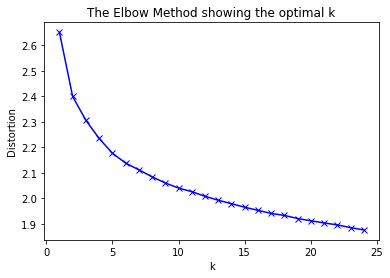

358.82267594337463 seconds


In [13]:
#Using the elbow plot method to try and determine how many clusters to go with


start = time.time()

distortions = []
K = range(1,12)
for k in K:
    print(k)
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(avg_vectors)
    distortions.append(sum(np.min(cdist(avg_vectors, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / avg_vectors.shape[0])

# Plot the elbow
plt.plot()
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('')
plt.show()
print(time.time() - start, "seconds")

In [14]:
#run the clustering algorithm
km = KMeans(n_clusters = 10)
km.fit(avg_vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [15]:

def find_k_closest(centroids, data, k=1, distance_norm=2):
    kdtree = cKDTree(data)
    distances, indices = kdtree.query(centroids, k)
    return indices

In [51]:
#find and print the reviews closest to the centroid, i.e. the most represntative reviews

centroids = km.cluster_centers_ 
cluster_closest_indices = find_k_closest(centroids, avg_vectors, k=10)
n = 1
for cluster in cluster_closest_indices:
    print("Cluster", n)
    
    for index in cluster:
        print(final_reviews_unprocessed[index])
        print("\n")
    print("\n\n\n")
    n += 1

Cluster 1
i update a few day ago and nothing much change i do like the new volume bar , but today when i open it up the subscription tab isn't fill with video , it's fill with suggestion . when i want to go look at the video of the people i'm subscribe to , i want to watch those video , not look at a slew of top category , some of which i'll never watch food , health beauty , tech , etc . while it's ok that you want me to look at their vids , this be not the right place for it . the subscription that i have can still be access individually at the top , but i can't see the video in a chronological order as i always have be able to . it's really stupid , please fix . i can't even tell it to go away , or revert back to what it be .


i don't have a subscription fee anymore . it just stop refresh and instead now show me best of youtube and recommend for you . i can clearly see the thumbnail for my sub above that so i know i'm sign in . this be beyond annoy as if i have to look through each

In [17]:
cluster_labels = km.fit_predict(avg_vectors)

In [ ]:
#use logistic regression to see what the most important words for each cluster is

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, r2_score, mean_squared_error

In [19]:
train_text, test_text, train_labels, test_labels = train_test_split(processed_reviews[nonzero_indeces], cluster_labels, random_state=2)
print(len(train_text))
print(len(test_text))
print(len(train_labels))
print(len(test_labels))

28263
9421
28263
9421


In [61]:
cv = CountVectorizer(min_df=1, ngram_range=(0,1))
cv_train_text = cv.fit_transform(train_text)
cv_test_text = cv.transform(test_text)

In [62]:
#run logistic regression model to predict cluster based on bag of words
lr = LogisticRegression()
lr.fit(cv_train_text, train_labels)
preds = lr.predict(cv_test_text)

#checking accuracy out of curiosity (although it's not really the point of any of this)
print(classification_report(test_labels, preds))

             precision    recall  f1-score   support

          0       0.79      0.74      0.76       867
          1       0.90      0.89      0.89       695
          2       0.81      0.83      0.82       338
          3       0.78      0.73      0.76       991
          4       0.79      0.89      0.83       756
          5       0.86      0.83      0.84       826
          6       0.80      0.78      0.79       937
          7       0.81      0.83      0.82      1801
          8       0.75      0.75      0.75      1770
          9       0.89      0.86      0.87       440

avg / total       0.80      0.80      0.80      9421



In [63]:
#get the largest coefficient for each of the clusters, i.e.
#the words most predictive of that cluster
#and print them out

cv_featurenames = cv.get_feature_names()
max_indeces = []

for n in range(0,10):
    coefs = lr.coef_[n]
    maxes = np.argsort(coefs)[-20:]
    max_indeces.append(maxes)
for i in range(0, len(max_indeces)):
    print("Cluster", i+1)
    top_features = [cv_featurenames[index] for index in max_indeces[i]]
    #reverse, because getting the coefficients this way gives you a list
    #where the last element is the highest number
    print(", ".join(reversed(top_features)))
    print("****************")

Cluster 1
subscrib, channel, subscript, sub, interest, suggest, luck, recommend, notif, blank, intent, post, pleaz, relev, tab, see, list, debat, distract, descript
****************
Cluster 2
wrong, retri, error, say, tap, someth, messag, keep, tri, pop, tell, reload, click, press, everi, go, electron, happen, sorri, alway
****************
Cluster 3
love, great, best, amaz, good, awesom, favorit, better, cool, nice, star, everyday, life, daili, pretti, enjoy, use, faster, year, easi
****************
Cluster 4
pro, io, version, batteri, updat, iphon, cmon, solid, air, mom, fex, crazi, app, bloodi, slightli, se, might, gig, hater, clearli
****************
Cluster 5
play, load, freez, video, buffer, black, begin, paus, show, sometim, start, forev, restart, minut, whenev, randomli, hour, stay, click, watch
****************
Cluster 6
forward, skip, button, doubl, second, screen, rewind, auto, hit, landscap, annoy, bar, fast, minim, ten, accident, shuffl, side, next, scrub
****************
C

# Write data to files outside repo to upload to projector.tensorflow.org

In [25]:
with open('../../large files/tf_projector_data.tsv', 'w', newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')
    for vector in avg_vectors:
        writer.writerow(vector)

In [32]:
cluster_closest_indices

array([[10779, 28609, 13883,  3735,  9411, 11006, 10860, 19779,  7595,
        20921, 11608, 10318, 13153, 21436, 13001,  6754, 18047, 32423,
        11402, 16019],
       [31520, 26769,  8158, 35864,  8356, 28057, 30809, 14230, 34377,
        16158, 26448,  6430, 26394,  8641, 31056, 31281, 24808, 27859,
        23570, 26250],
       [27256, 35484, 21095, 23566, 27872, 33995, 21630, 23640, 24490,
        28944, 19496, 23391,  1203, 22147, 22889, 15253, 23143, 23272,
        23356, 23961],
       [11110,  7519, 20770, 31866, 31197, 29505, 30074, 17563, 33006,
        12168, 20024, 18059, 22487, 11533,  8024, 15755, 29798, 30302,
        19776, 35829],
       [27479, 27462, 30600, 31739, 25071, 36515, 36483, 20204, 33102,
        24111, 34172, 34940, 34822,  7576, 30436, 19425, 27042, 36051,
        33200, 31854],
       [30723,  9543, 30301, 19629,  8212, 33624, 20224,  6076,  8961,
        35915, 18638, 20273, 30493, 17944, 18898, 19353, 10086, 21116,
        17097, 37067],
       [26

In [42]:
is_closest = [0]*len(final_reviews_unprocessed)
i = 0
for cluster in cluster_closest_indices:    
    for index in cluster: 
        is_closest[index] = i
    i += 1

In [43]:
with open('../../large files/tf_projector_metadata.tsv', 'w', newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')
    writer.writerow(['review_text', 'cluster_label', 'is_closest'])
    for i in range(0, len(final_reviews_unprocessed)):
        writer.writerow([final_reviews_unprocessed[i], cluster_labels[i], is_closest[i]])